In [1]:
import json
data = list()
for filename in [
    'results/2020-01-23T09:26:02.691402-05:00.json']:
    with open(filename, 'r') as infile:
        data += json.load(infile)

In [2]:
EPS = 1e-9
for entry in data:
    entry['auc'] = sum(entry['accuracy'])
    if (entry['optimizer'] == 'sgd') and (abs(float(entry['momentum'])) > EPS):
        entry['optimizer'] = 'momentum'  # separate sgd with and without momentum
    if entry['loss'] == 'squared_error':
        entry['optimizer'] = entry['optimizer'] + '_SE'
    if entry['loss'] == 'TD':
        entry['optimizer'] = entry['optimizer'] + '_TD'

In [3]:
from tools import *
temp = dict()
for entry in data:
    key = get_hyperparameter_key(entry)
    if key in temp:
        temp[key].append(entry['auc'])
    else:
        temp[key] = [entry['auc']]
auc_table = list()
for key, value in temp.items():
    entry = dict(key._asdict())
    entry['auc_mean'] = np.mean(value)
    entry['auc_stderr'] = np.std(value) / np.sqrt(len(value))
    auc_table.append(entry)
auc_table = pd.DataFrame(list_of_dicts_to_dict_of_lists(auc_table))
auc_table.head(n=10)

,beta_1,beta_2,lr,momentum,optimizer,rho,loss,auc_mean,auc_stderr
0,NaN,NaN,0.010000,0.0,sgd_TD,NaN,TD,5.343650e+09,1.495393e+09
1,NaN,NaN,0.100000,0.0,sgd_TD,NaN,TD,1.583705e+10,3.664880e+09
2,0.9,0.999,0.000001,NaN,adam_SE,NaN,squared_error,NaN,NaN
3,NaN,NaN,0.000001,0.0,sgd_SE,NaN,squared_error,NaN,NaN
4,NaN,NaN,0.000010,NaN,rms_TD,0.9,TD,5.527207e+04,5.787123e+02
5,0.9,0.999,0.001000,NaN,adam_TD,NaN,TD,1.128325e+07,4.154040e+06
6,NaN,NaN,0.000100,0.9,momentum_SE,NaN,squared_error,NaN,NaN
7,0.9,0.999,0.000010,NaN,adam_TD,NaN,TD,5.667571e+04,7.738315e+02
8,0.9,0.999,0.000001,NaN,adam_TD,NaN,TD,NaN,NaN
9,NaN,NaN,0.000001,NaN,rms_TD,0.9,TD,NaN,NaN


In [4]:
best_auc_table = list()
for optimizer in auc_table['optimizer'].unique():
    try:
        sub_table = auc_table[auc_table['optimizer'] == optimizer]
        best_auc_table.append((sub_table.loc[sub_table['auc_mean'].idxmin()]).to_dict())
    except TypeError:
        pass
best_auc_table = pd.DataFrame(list_of_dicts_to_dict_of_lists(best_auc_table))
best_auc_table.head(n=10)

,beta_1,beta_2,lr,momentum,optimizer,rho,loss,auc_mean,auc_stderr
0,NaN,NaN,0.000001,0.0,sgd_TD,NaN,TD,5.318865e+04,2.368935e+01
1,NaN,NaN,0.000010,NaN,rms_TD,0.9,TD,5.527207e+04,5.787123e+02
2,0.9,0.999,0.000010,NaN,adam_TD,NaN,TD,5.667571e+04,7.738315e+02
3,NaN,NaN,0.010000,0.9,momentum_TD,NaN,TD,3.876282e+10,1.062357e+10
4,NaN,NaN,NaN,NaN,constant,NaN,None,3.001192e+04,5.606474e+00


In [5]:
best_keys = {row['optimizer']: get_hyperparameter_key(row.to_dict()) for _, row in best_auc_table.iterrows()}
best_by_optimizer = dict()
for entry in data:
    optimizer = entry['optimizer']
    try:
        if get_hyperparameter_key(entry) == best_keys[optimizer]:
            if optimizer not in best_by_optimizer:
                best_by_optimizer[optimizer] = [entry]
            else:
                best_by_optimizer[optimizer].append(entry)
    except KeyError:
        pass

In [6]:
best_by_optimizer_summary = {row['optimizer']: row.to_dict() for _, row in best_auc_table.iterrows()}
for key1 in best_by_optimizer_summary.keys():
    for key2 in result_labels:
        try:
            values = np.array([item[key2] for item in best_by_optimizer[key1]])
            best_by_optimizer_summary[key1][key2 + '_mean'] = np.mean(values, axis=0)
            best_by_optimizer_summary[key1][key2 + '_stderr'] = np.std(values, axis=0) / np.sqrt(values.shape[0])
        except KeyError:
            pass

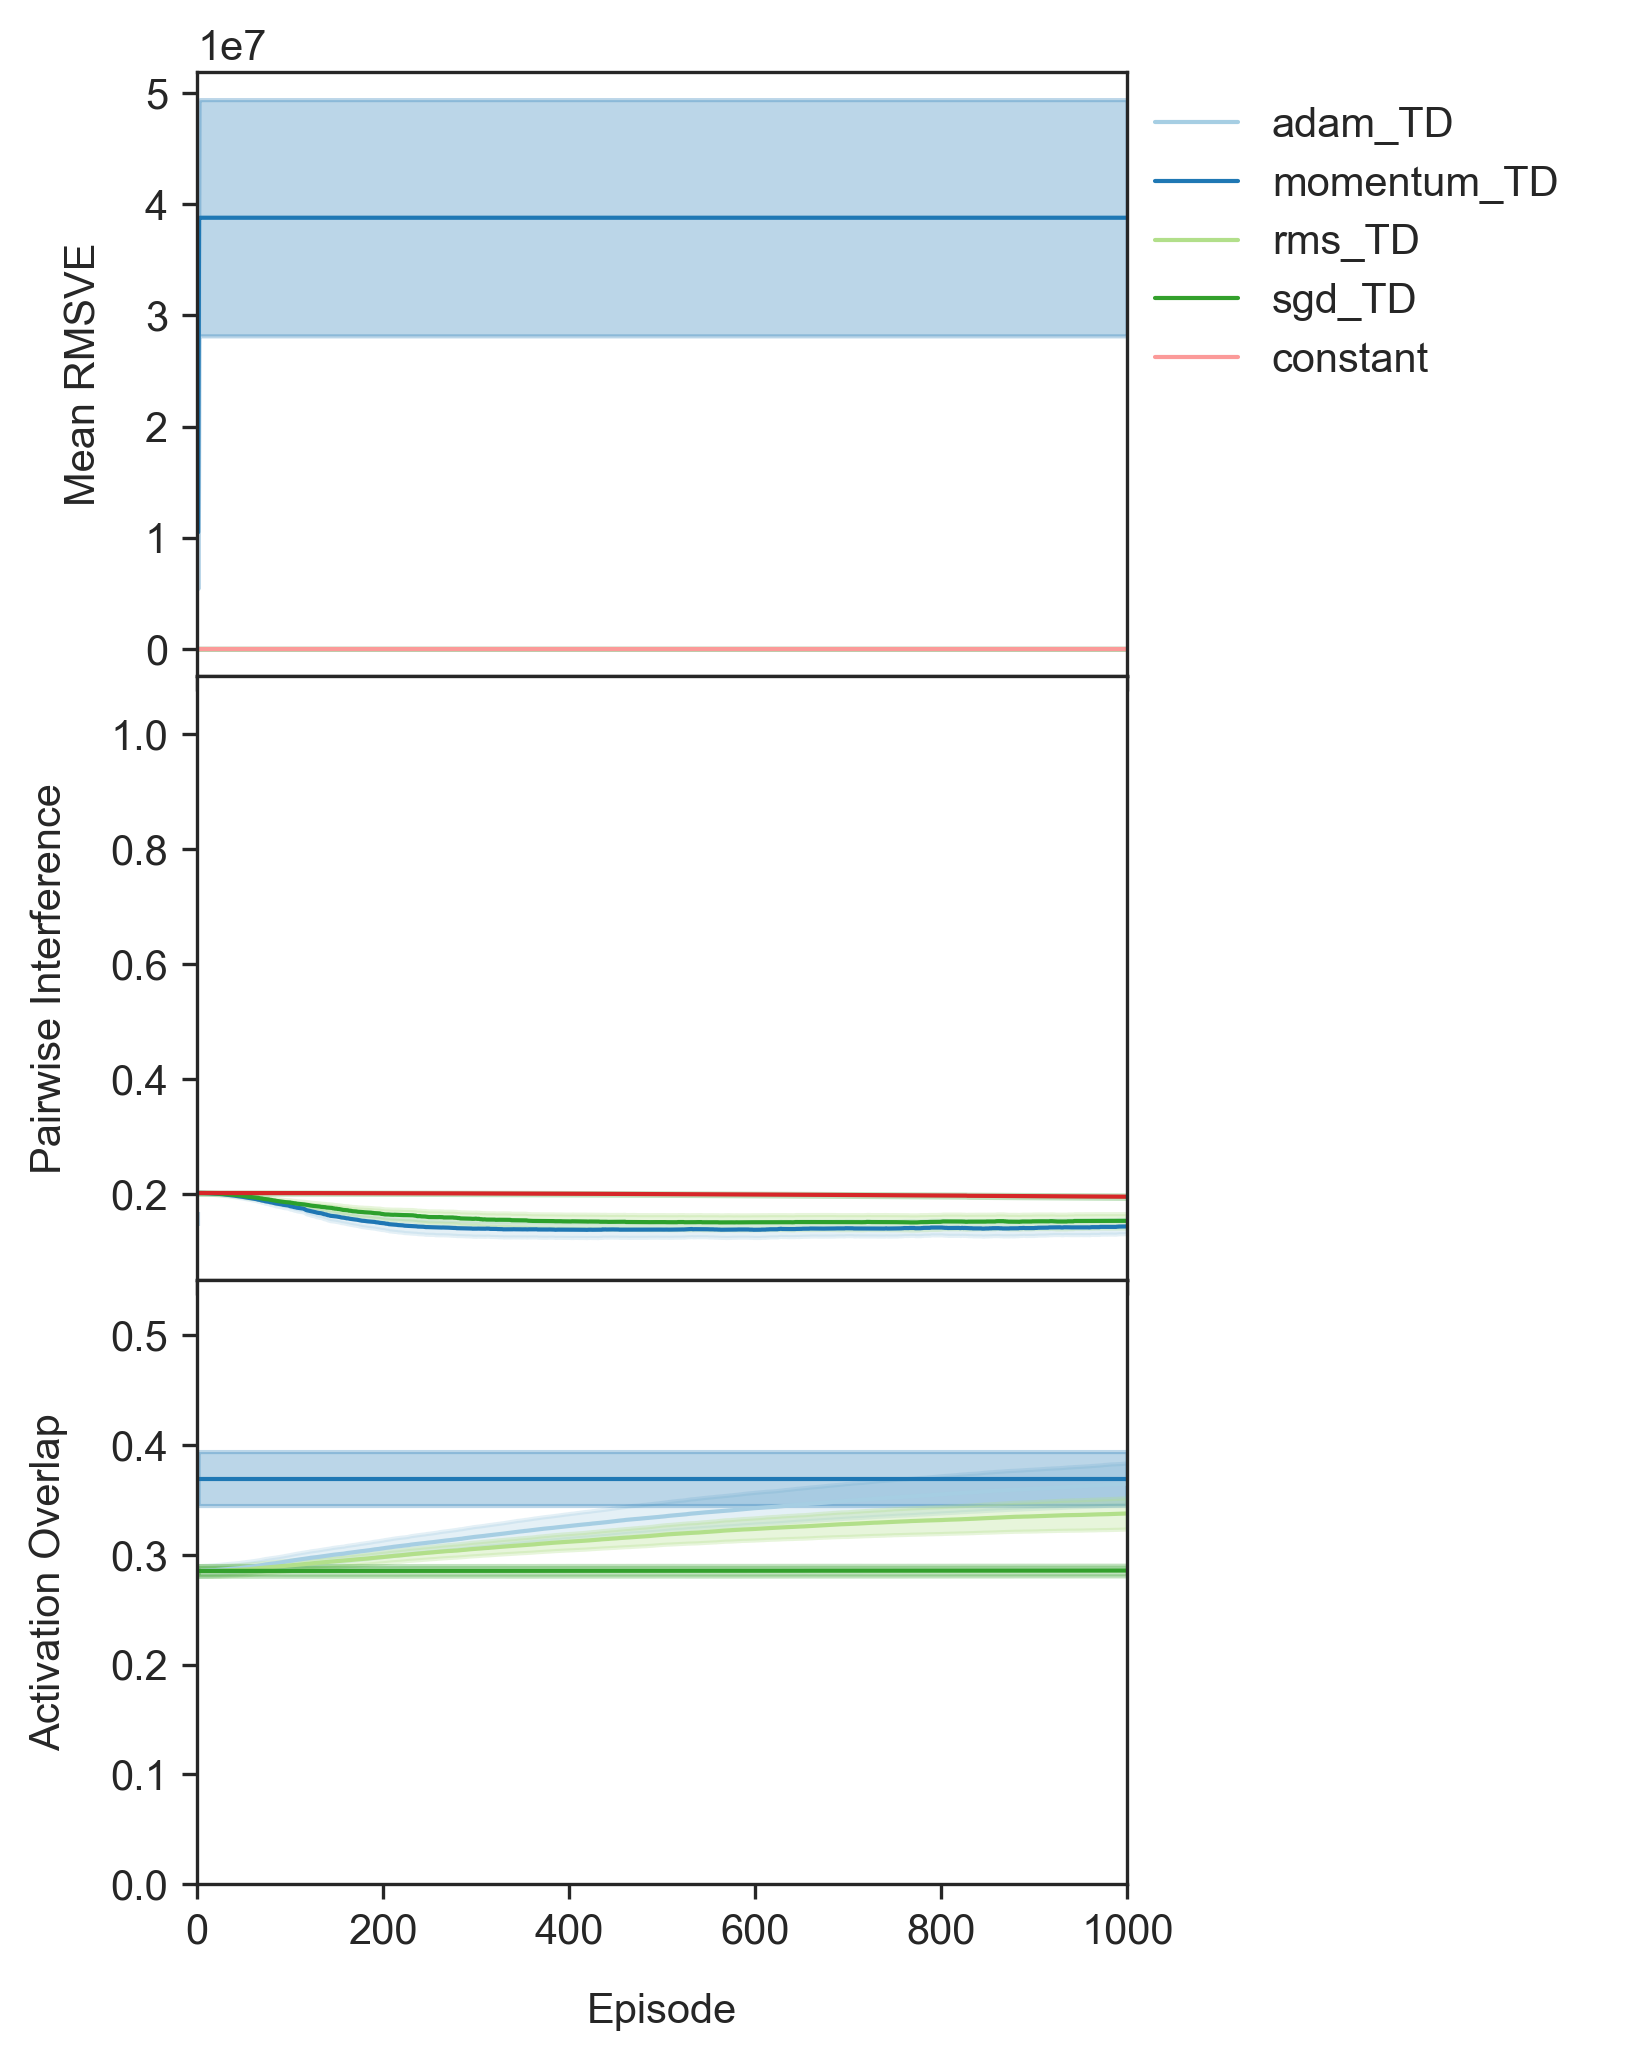

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')
colors = sns.color_palette('Paired', n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1)
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax2.set_ylim(0.05, 1.1)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_ylim(0.0, 0.55)
ax3.set_xlim(0, 1000)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.83), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('results.png', bbox_inches='tight')